In [1]:
# Imports
import networkx as nx  # Core network analysis package
import numpy as np  # Core numeric package
import matplotlib.pyplot as plt  # Core plotting package
import dzcnapy_plotlib as dzcnapy  # Optional library containing pre-made plotting options
import csv  # Package for csv I/O
from collections import Counter  # Import only the Counter
from scipy.optimize import curve_fit  # Mainly to fit the degree distribution with a power-law
import pickle  # To read and write to file objects. Currently used for Girvan-Newman

# Currently unusued imports
#import warnings  # To suppress some warnings
#from multiprocessing.dummy import Pool as ThreadPool
#import powerlaw  # To test the power law distribution

In [2]:
# Options
np.set_printoptions(threshold=np.nan)  # numpy option to print all the array instead of head and tail

%config IPCompleter.greedy=True  # Auto-complete option. Press TAB to activate

In [3]:
dep_G = nx.read_graphml("departments_weighted.graphml")

## Connected components

In [4]:
n_conn_comp = nx.number_connected_components(dep_G)
print("# of connected components: " + str(n_conn_comp))

# of connected components: 1


## Degree distribution

In [5]:
node_and_degrees = dep_G.degree  # Iterator over 2-tuples (node, degree)

node_degrees = np.array(list(deg for _, deg in dep_G.degree))  # Array of degrees

In [6]:
# Count the number of nodes for each degree
deg_counter = Counter(node_degrees)

# Create the array of the existing degrees and the array of corresponding number
degrees = np.array(sorted(deg_counter.keys()))
deg_n = np.array(list(deg_counter[deg] for deg in degrees))

# Find and print the maximum degree
max_degree = max(degrees)
print("Max degree: " + str(max_degree))

# Compute the log of both arrays, to verify the power law
mask_not_null = np.all([degrees != 0, deg_n != 0], axis = 0)  # Make sure to take only values > 0, since we are applying the log
log_degrees = np.log(degrees[mask_not_null])
log_deg_n = np.log(deg_n[mask_not_null])

Max degree: 42


In [7]:
# Definition of functions for fitting the distribution of 
def power(x, c, k):
    return c*(x**(-k))

def linear(x, m, c):
    return m*x + c

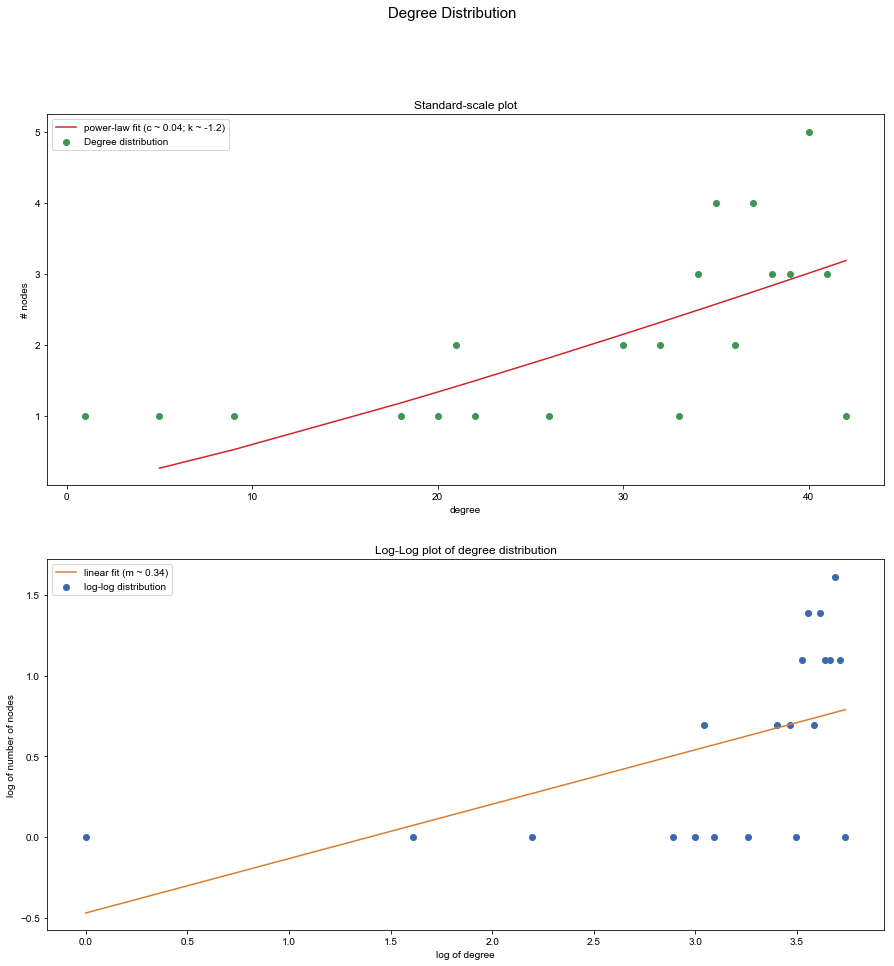

In [8]:
# Create a Figure divided in two Axes (subplots)
fig, (ax, ax_log) = plt.subplots(2, 1)
fig.set_size_inches(15, 15)
fig.suptitle("Degree Distribution", fontsize = 15)

# In the first Axis draw the standard-scale distribution of degrees
ax.set_xlabel('degree')
ax.set_ylabel('# nodes')
ax.set_title("Standard-scale plot")
ax.scatter(degrees, deg_n, marker = 'o', facecolors='#3e9651', edgecolors='#3e9651', label = 'Degree distribution')
pow_params = curve_fit(power, degrees[1:], deg_n[1:])
ax.plot(degrees[1:], power(degrees[1:], *pow_params[0]), color='#cc2529', label = 'power-law fit (c ~ '+format(pow_params[0][0], '.2g')+'; k ~ '+format(pow_params[0][1], '.2g')+')')
ax.legend()

# In the second Axis draw the log-log distribution of degrees
ax_log.set_xlabel('log of degree')
ax_log.set_ylabel('log of number of nodes')
ax_log.set_title("Log-Log plot of degree distribution")
ax_log.scatter(log_degrees, log_deg_n, marker = 'o', facecolors='#396ab1', edgecolors='#396ab1', label = 'log-log distribution')
lin_params = curve_fit(linear, log_degrees, log_deg_n)
ax_log.plot(log_degrees, linear(log_degrees, *lin_params[0]), color='#da7c30', label='linear fit (m ~ '+format(lin_params[0][0], '.2g')+')')
ax_log.legend()

# Save the figure as png and plot it
plt.savefig("DEP_degree_distribution.png")
plt.show()

In [9]:
avg_deg = np.mean(node_degrees)
var_deg = np.var(node_degrees)
std_deg = np.std(node_degrees)

print("Average degree: " + str(avg_deg))
print("Variance of degree distribution: " + str(var_deg))

Average degree: 32.3333333333
Variance of degree distribution: 96.1746031746


### Distance distribution

In [10]:
def distance_distribution(DG, plotsave=None):
    nodes = DG.nodes()

    distances = []
    for node in nodes:
        distances = distances + list((nx.shortest_path_length(DG, source = node)).values())
    
    diameter = max(distances)

    distances = np.array(distances)
    dist_freq = Counter(distances)
    
    dist_freq = np.array(list(dist_freq.values()))
    dist_freq[0] = 0  # In the computation of statistics we exclude null distances since they mean nothing
    
    # If the graph is undirected, halve the distances since they are counted twice in the step before
    if isinstance(DG, nx.classes.graphviews.SubGraph):
        for i in range(len(dist_freq)):
            dist_freq[i] /= 2
            
    plt.plot(dist_freq, linestyle='dotted', color = 'red')
    plt.scatter(range(len(dist_freq)), dist_freq, linestyle='dotted', color = 'blue')
    if plotsave is not None:
        plt.savefig(plotsave)

    return np.average(distances), np.std(distances)

Average distance: 1.22902494331
Standard deviation of distance: 0.480618650657


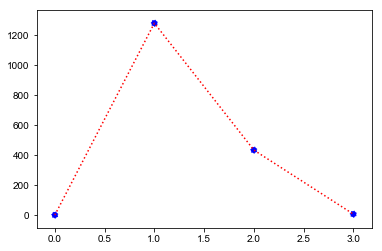

In [11]:
avg_dist, std_dist = distance_distribution(dep_G, "DEP_distance_distribution.png")
print("Average distance: " + str(avg_dist))
print("Standard deviation of distance: " + str(std_dist))

In [12]:
eccentricities = nx.eccentricity(dep_G)
radius = min(eccentricities.values())  # Manual radius
diameter = max(eccentricities.values())  # Manual diameter

print("Radius of the giant connected component: " + str(radius))
print("Diameter of the giant connected component: " + str(diameter))

Radius of the giant connected component: 2
Diameter of the giant connected component: 3


### Centrality
#### Degree Centrality

In [13]:
dict1 = nx.degree_centrality(dep_G)
l = []
for key, value in dict1.items():
    l.append((key, value))

sorted_deg_cent_arr = np.array(sorted(l, key=(lambda x: x[1]), reverse = True))
central_node = int(sorted_deg_cent_arr[0][0])

print(sorted_deg_cent_arr)
print("The node with highest degree centrality is #" + str(central_node))

[['36' '1.024390243902439']
 ['1' '1.0']
 ['34' '1.0']
 ['15' '1.0']
 ['14' '0.975609756097561']
 ['26' '0.975609756097561']
 ['4' '0.975609756097561']
 ['38' '0.975609756097561']
 ['35' '0.975609756097561']
 ['9' '0.951219512195122']
 ['10' '0.951219512195122']
 ['37' '0.951219512195122']
 ['7' '0.926829268292683']
 ['8' '0.926829268292683']
 ['13' '0.926829268292683']
 ['25' '0.9024390243902439']
 ['11' '0.9024390243902439']
 ['22' '0.9024390243902439']
 ['6' '0.9024390243902439']
 ['21' '0.8780487804878049']
 ['19' '0.8780487804878049']
 ['17' '0.8536585365853658']
 ['20' '0.8536585365853658']
 ['0' '0.8536585365853658']
 ['40' '0.8536585365853658']
 ['5' '0.8292682926829269']
 ['16' '0.8292682926829269']
 ['32' '0.8292682926829269']
 ['23' '0.8048780487804879']
 ['28' '0.7804878048780488']
 ['2' '0.7804878048780488']
 ['29' '0.7317073170731707']
 ['27' '0.7317073170731707']
 ['3' '0.6341463414634146']
 ['31' '0.5365853658536586']
 ['24' '0.5121951219512195']
 ['12' '0.5121951219512

#### Betweenness Centrality

In [14]:
dict1 = nx.betweenness_centrality(dep_G)
l = []
for key, value in dict1.items():
    l.append((key, value))

sorted_deg_cent_arr = np.array(sorted(l, key=(lambda x: x[1]), reverse = True))
central_node = int(sorted_deg_cent_arr[0][0])

print(sorted_deg_cent_arr)
print("The node with highest betweenness centrality is #" + str(central_node))

[['4' '0.055166378078599185']
 ['36' '0.022346355011606027']
 ['15' '0.019566671957532727']
 ['26' '0.014660071105809922']
 ['10' '0.012801709875138793']
 ['1' '0.01242765582461415']
 ['34' '0.01242765582461415']
 ['38' '0.010739590665847487']
 ['21' '0.010191960280513971']
 ['37' '0.00995251870815709']
 ['7' '0.00810298619082838']
 ['14' '0.007886908631427932']
 ['35' '0.007886908631427932']
 ['8' '0.007784660595328873']
 ['19' '0.006510237185946232']
 ['9' '0.006442745911685662']
 ['11' '0.005751736385460575']
 ['25' '0.0056567859769399865']
 ['13' '0.00450902694830952']
 ['6' '0.004329197233822832']
 ['22' '0.0040585649036192694']
 ['28' '0.003187283289779538']
 ['40' '0.0031664637088388917']
 ['17' '0.002395533967925008']
 ['23' '0.002359861466254862']
 ['20' '0.0017791065570877534']
 ['0' '0.001738998768706882']
 ['32' '0.0016720167765125282']
 ['2' '0.00162843389231061']
 ['5' '0.001044089655982287']
 ['16' '0.0010401109356727076']
 ['27' '0.0007977455358169879']
 ['29' '0.000774

### Clustering Coeff

In [15]:
avg_clustering = nx.average_clustering(dep_G)
print("Averge clustering for undirected graph: " + str(avg_clustering))

Averge clustering for undirected graph: 0.8750658329738243


In [16]:
print("Clustering of central node (" + str(central_node) + "): " + str(nx.clustering(dep_G, str(central_node))))

Clustering of central node (4): 0.8108108108108109


### Density

In [17]:
print("density of department network:", str(nx.density(dep_G)))

density of department network: 0.7886178861788617


### Assortativity

In [18]:
lista = nx.degree(dep_G)
assortativity = np.zeros(len(degrees))
avg_neighbor_deg = nx.average_neighbor_degree(dep_G, source = 'out', target = 'out')
for i, deg in zip(range(len(degrees)), degrees):
    assortativity[i] = np.mean([avg_neighbor_deg[node_str] for node_str, degree in lista if degree == deg])

Degree Assortativity Coefficient: -0.17860710394541846


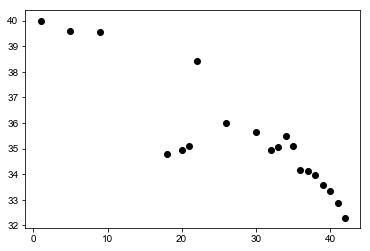

In [19]:
print("Degree Assortativity Coefficient: " + format(nx.degree_assortativity_coefficient(dep_G), ''))
plt.figure(1)
plt.scatter(degrees, assortativity)
plt.savefig("DEP_assortativity.png")

The graph of departments seems a bit disassortative.